In [1]:
import pandas as pd
import torch
from ctcovseg import plot_segmentations, nii_to_np, Config, SegmentationModel

In [2]:
meta = pd.read_csv('../input/covid19-ct-scans/metadata.csv')

meta.head(10)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
5,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
6,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
7,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
8,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
9,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [3]:
row = meta.iloc[0]
image = nii_to_np(row['ct_scan'])
mask = nii_to_np(row['lung_and_infection_mask'])

In [4]:
print(image.shape)

(512, 512, 301)


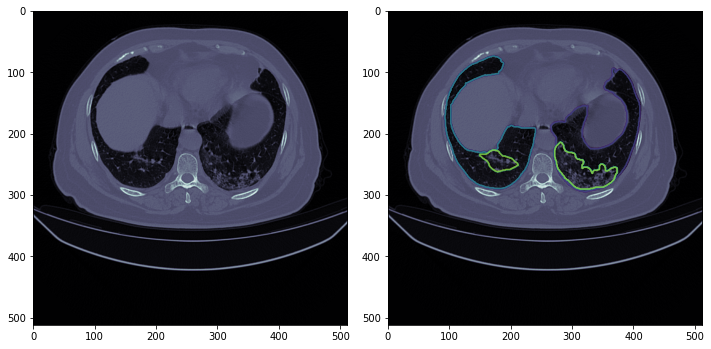

In [5]:
slice_i = 100
image_slice = image[..., slice_i]
mask_slice = mask[..., slice_i]

plot_segmentations(image_slice, [mask_slice])

In [6]:
config = Config()

model = SegmentationModel(config, 0)
state_dict = torch.load(f"../models/{config.experiment_name}.ckpt", map_location="cpu")['state_dict']
model.load_state_dict(state_dict)

valid_aug = config.valid_aug

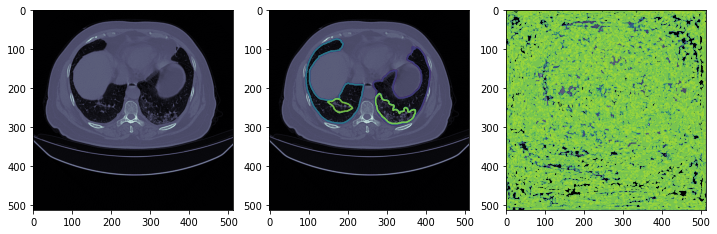

In [7]:
import numpy as np

slice_i = 100
image_slice = image[..., slice_i]
mask_slice = mask[..., slice_i]

train_image = np.expand_dims(image_slice, 2)
if valid_aug is not None:
    train_image = valid_aug(image=train_image)["image"]
train_image = np.moveaxis(train_image, 2, 0)
train_image = np.expand_dims(train_image, 0)
train_image = torch.from_numpy(train_image)

with torch.no_grad():
    out_mask = np.argmax(model(train_image)[0].numpy(), axis=0)

plot_segmentations(image_slice, [mask_slice, out_mask])
